# **FinQuery: Intelligent Banking Intent Classification for Customer Support**

# BUSINESS UNDERSTANDING

- I aim to build a robust intent-classification model for BANKING77, which contains 77 fine-grained customer banking service intents.
- This will help automated customer support route queries correctly, improving response time and customer satisfaction.

# DATA UNDERSTANDING

- Train set: 10,003 examples
- Test set:  3,080 examples
- Number of Intents: 77
- Data Source: https://huggingface.co/datasets/PolyAI/banking77

# PROJECT AIM

- Accurately classify user queries into one of 77 intents

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Creating Dataframe from the training Dataset
# Load the training dataset

train_df = pd.read_csv("train.csv")
train_df.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [3]:
# Creating Dataframe from the test Dataset
# Load the test dataset

test_df = pd.read_csv("test.csv")
test_df.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


In [4]:
# Examining the Data

print(f"The Training Data Shape is: {train_df.shape}")
print(f"The Test Data Shape is: {test_df.shape}")

The Training Data Shape is: (10003, 2)
The Test Data Shape is: (3080, 2)


- Our Training data has 10,003 records and 2 columns
- Our Test data has 3,080 records and 2 columns

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


- The datatype of the data in the train_df both columns i.e., text and category is string i.e, text

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.2+ KB


- The datatype of the data in the test_df both columns i.e., text and category is string i.e, text

In [7]:
# Checking out the missing data in the training data

train_df.isna().sum()

text        0
category    0
dtype: int64

In [8]:
# Checking out the missing data in the test data

test_df.isna().sum()

text        0
category    0
dtype: int64

In [9]:
# Checking out for duplicates in the training data

len(train_df[train_df.duplicated(keep="first")])

0

In [10]:
# Checking out for duplicates in the test data 

len(test_df[test_df.duplicated(keep="first")])

0

- In both datasets there is neither missing data nor duplicates i.e., our data is pretty much clean

## **Exploratory Data Analysis**

### **Distribution of Intent category**

In [11]:
# Counting top 10 distribution of intent category in the training data

category_counts = train_df['category'].value_counts().sort_values(ascending=False).head(10)
category_counts

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
declined_cash_withdrawal                            173
transfer_fee_charged                                172
balance_not_updated_after_bank_transfer             171
transfer_not_received_by_recipient                  171
Name: count, dtype: int64

#### **Visualize category distribution**

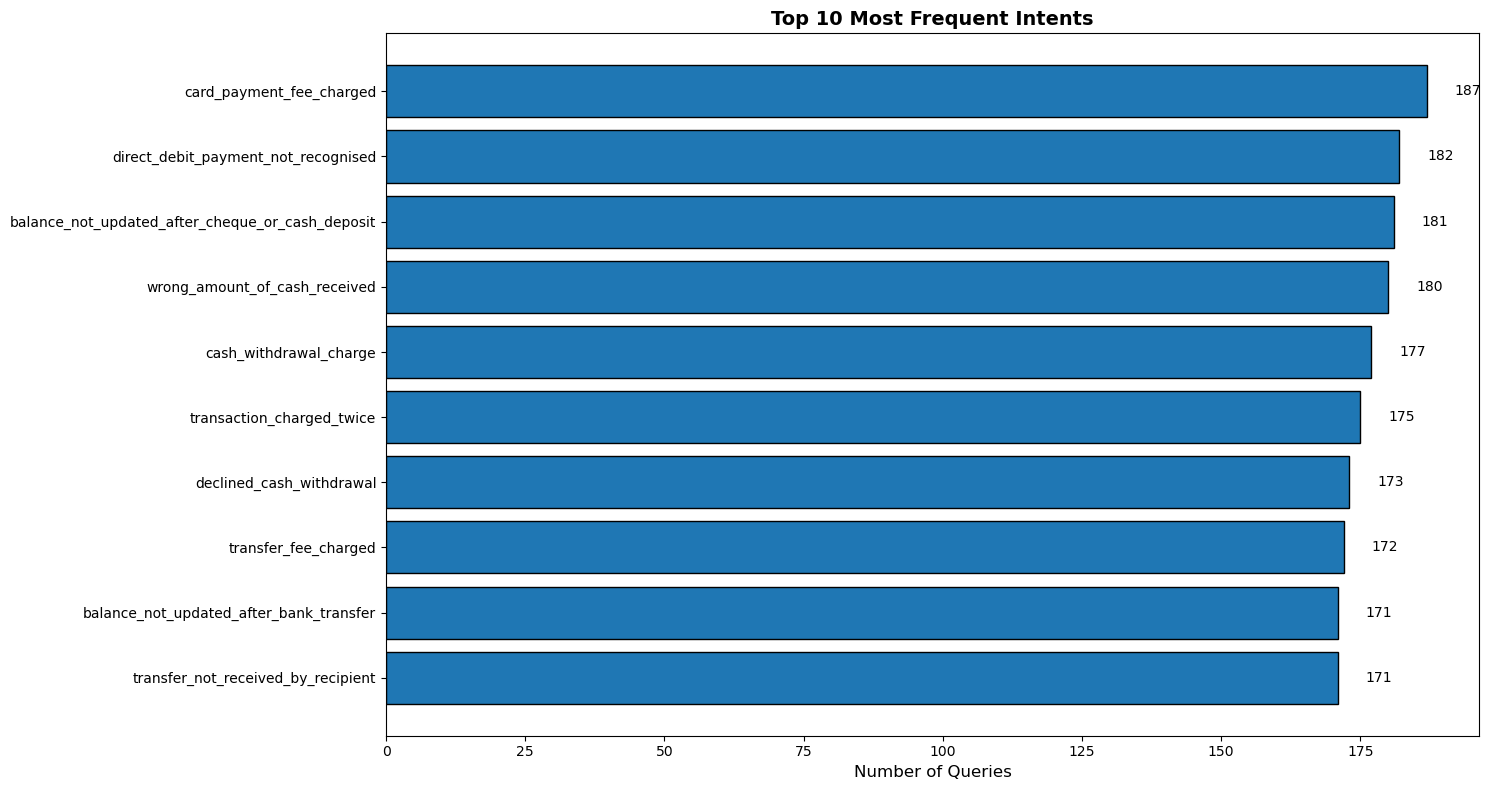

In [12]:
# Intent categories by frequency

plt.figure(figsize=(15, 8))
bars = plt.barh(category_counts.index, category_counts.values, edgecolor='black')
plt.gca().invert_yaxis()  # Highest counts on top
plt.xlabel("Number of Queries", fontsize=12)
plt.title("Top 10 Most Frequent Intents", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# Annotate each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', fontsize=10)
plt.tight_layout()
plt.show();

#### **WordCloud of full training text**

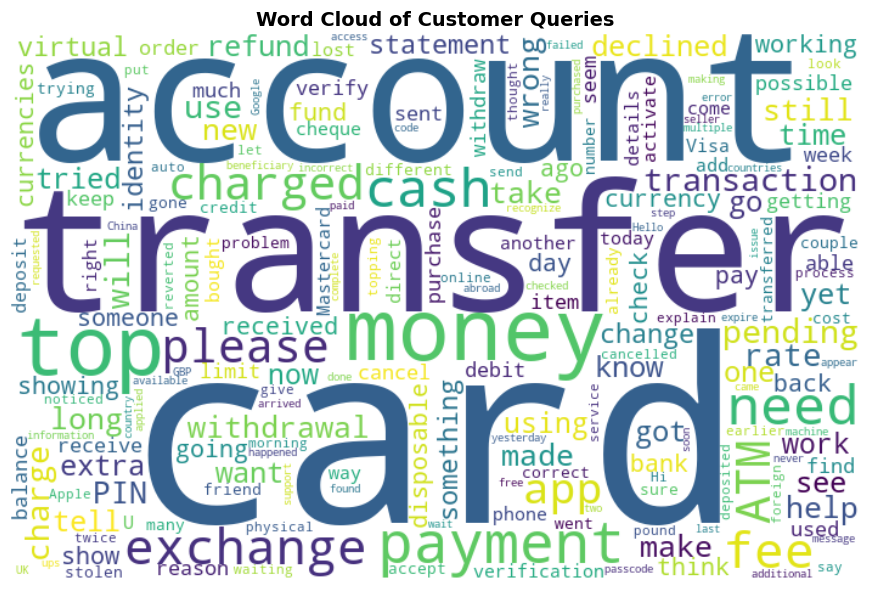

In [13]:
all_text = " ".join(train_df['text'].tolist())
wordcloud = WordCloud(
    width=700,
    height=450,
    background_color='white',
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Queries", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show();

## **Data Preprocessing**

In [14]:
def clean_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # remove any leading or trailing whitespace characters
    text = text.strip()

    return text

I am keeping the preprocessing minimal—just lowercasing and whitespace normalization—for a few reasons:

1. **TF‑IDF’s built‑in tokenization**  
   Scikit‑learn’s `TfidfVectorizer` already:
   * Splits on non‑alphanumeric boundaries,
   * Lowercases (if you pass `lowercase=True`),
   * Can remove stopwords automatically (via `stop_words='english'`),
   * And builds the n‑gram vocabulary for you.  
     Adding a separate tokenization step outside of the vectorizer would be redundant.

2. **Stopword removal can hurt fine‑grained intents**  
   In a 77‑way banking intent task, words like “to”, “on”, “did”, or “my” can carry important signals—for example:  
   _“did my payment go through?”_ vs. _“why is my payment delayed?”_  
   So we often keep stopwords in the bag‑of‑words representation or let the vectorizer handle them selectively.

3. **Lemmatization adds extra complexity with limited gain**
   * Lemmatization (via spaCy or NLTK) can reduce inflectional forms (e.g., “payments” → “payment”), but banking queries already tend to use a consistent vocabulary (“withdraw”, “withdrawal”; “pay”, “payment”).

In [15]:
# Clean the text columns

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Sample cleaned text
train_df[['text','clean_text']].sample(3)

,text,clean_text
7643,I want to transfer a sum of money from another...,i want to transfer a sum of money from another...
4158,What do I have to do to get a Visa card?,what do i have to do to get a visa card
8974,Are there any discounts for frequent currency ...,are there any discounts for frequent currency ...


#### **Train/Validation Split**

In [16]:
# Determining Target vector (y) and Feature Matrix (X)

X = train_df['clean_text']
y = train_df['category']

print("TF-IDF matrix feature shape:", X.shape)
print("Our Target Vector Shape is:", y.shape)

TF-IDF matrix feature shape: (10003,)
Our Target Vector Shape is: (10003,)


In [17]:
#performing train test split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#checking shapes of the both X_train and X_test sets
print("X_train_raw:", X_train_raw.shape, "X_test_raw:", X_test_raw.shape)

X_train_raw: (8002,) X_test_raw: (2001,)


#### **Feature Extraction (TF-IDF)**

In [18]:
# Create Vectorizer for text classification

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Capture longer phrases that might be important
    min_df=2,            # Removes terms that appear in fewer than 2 documents
    max_df=0.95,         # Removes terms that appear in more than 95% of documents
    sublinear_tf=True    # Reduces the weight of terms that occur very frequently in a document
)

In [19]:
# Fit vectorizer on training text

X_train = tfidf_vectorizer.fit_transform(X_train_raw)
X_test = tfidf_vectorizer.transform(X_test_raw)

In [20]:
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (8002, 18197) X_test shape: (2001, 18197)


## **MODELLING**

### **Linear SVC Model**

In [21]:
# Training LinearSVC Model

# Create Model
svc_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)

# Fit the Model
svc_model.fit(X_train, y_train)

# Predict
svc_prediction = svc_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
svc_accuracy = accuracy_score(y_test, svc_prediction)
svc_precision = precision_score(y_test, svc_prediction, average='macro')
svc_recall = recall_score(y_test, svc_prediction, average='macro')
svc_f1_score = f1_score(y_test, svc_prediction, average='macro')

print(f"SVC Model Accuracy: {svc_accuracy:.4f}")
print(f"SVC model Precision: {svc_precision:.4f}  (macro‐avg)")
print(f"SVC Model Recall: {svc_recall:.4f}  (macro‐avg)")
print(f"SVC F1 Score: {svc_f1_score:.4f}  (macro‐avg)");

SVC Model Accuracy: 0.8691
SVC model Precision: 0.8732  (macro‐avg)
SVC Model Recall: 0.8714  (macro‐avg)
SVC F1 Score: 0.8697  (macro‐avg)


In [22]:
print("Classification Report - LinearSVC")
print(classification_report(y_test, svc_prediction, zero_division=0));

Classification Report - LinearSVC
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.86      0.97      0.91        32
                                activate_my_card       0.97      0.97      0.97        32
                                       age_limit       1.00      0.95      0.98        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       1.00      0.82      0.90        17
                                automatic_top_up       1.00      0.92      0.96        25
         balance_not_updated_after_bank_transfer       0.84      0.79      0.82        34
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.92      0.90        36
                         beneficiary_not_allowed       0.84      0.87      0.86        31
                                 cancel_transfer       0.97      

### **Logistic Regression Model**

In [23]:
# Training Logistic Regression Model

# Create model
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

# Fit model
lr_model.fit(X_train, y_train)

# Predict
lr_prediction = lr_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
lr_accuracy = accuracy_score(y_test, lr_prediction)
lr_precision = precision_score(y_test, lr_prediction, average='macro')
lr_recall = recall_score(y_test, lr_prediction, average='macro')
lr_f1_score = f1_score(y_test, lr_prediction, average='macro')

print(f"Logistic Regression Model Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression model Precision: {lr_precision:.4f}")
print(f"Logistic Regression Model Recall: {lr_recall:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1_score:.4f}");

Logistic Regression Model Accuracy: 0.8331
Logistic Regression model Precision: 0.8416
Logistic Regression Model Recall: 0.8396
Logistic Regression F1 Score: 0.8360


In [24]:
print("Classification Report - Logistic Regression")
print(classification_report(y_test, lr_prediction, zero_division=0));

Classification Report - Logistic Regression
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.94      0.95        32
                                activate_my_card       1.00      0.91      0.95        32
                                       age_limit       1.00      0.91      0.95        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.88      0.88      0.88        17
                                automatic_top_up       0.95      0.84      0.89        25
         balance_not_updated_after_bank_transfer       0.79      0.68      0.73        34
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.86      0.85        36
                         beneficiary_not_allowed       0.86      0.81      0.83        31
                                 cancel_transfer       

### **Naive Bayes Model**

In [25]:
# Training the Naive Bayes model

# Create Model
nb_model = MultinomialNB()

# Fit Model
nb_model.fit(X_train, y_train)

# Predict on test set
nb_predictions = nb_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, average='macro')
nb_recall = recall_score(y_test, nb_predictions, average='macro')
nb_f1_score = f1_score(y_test, nb_predictions, average='macro')

# Evaluation results
print(f"Naive Bayes Accuracy:         {nb_accuracy:.4f}")
print(f"Naive Bayes Precision:        {nb_precision:.4f}  (macro avg)")
print(f"Naive Bayes Recall:           {nb_recall:.4f}  (macro avg)")
print(f"Naive Bayes F1 Score:         {nb_f1_score:.4f}  (macro avg)\n")

Naive Bayes Accuracy:         0.7881
Naive Bayes Precision:        0.8130  (macro avg)
Naive Bayes Recall:           0.7612  (macro avg)
Naive Bayes F1 Score:         0.7682  (macro avg)



In [26]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, nb_predictions, zero_division=0))

Classification Report:

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.87      0.84      0.86        32
                                activate_my_card       0.63      0.97      0.77        32
                                       age_limit       1.00      0.91      0.95        22
                         apple_pay_or_google_pay       0.86      1.00      0.93        25
                                     atm_support       0.77      0.59      0.67        17
                                automatic_top_up       0.96      0.88      0.92        25
         balance_not_updated_after_bank_transfer       0.77      0.68      0.72        34
balance_not_updated_after_cheque_or_cash_deposit       0.63      0.92      0.75        36
                         beneficiary_not_allowed       0.76      0.81      0.78        31
                                 cancel_transfer       0.85      0.94      

#### **Getting Best Performing Model**

In [27]:
model_names = ['Logistic Regression', 'Linear SVC', 'Naive Bayes']
accuracy = [lr_accuracy, svc_accuracy, nb_accuracy]
f1 = [lr_f1_score, svc_f1_score, nb_f1_score]
precision = [lr_precision, svc_precision, nb_precision]
recall = [lr_recall, svc_recall, nb_recall]

In [28]:
# Create a DataFrame
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Macro F1': f1,
    'Macro Precision': precision,
    'Macro Recall': recall
})

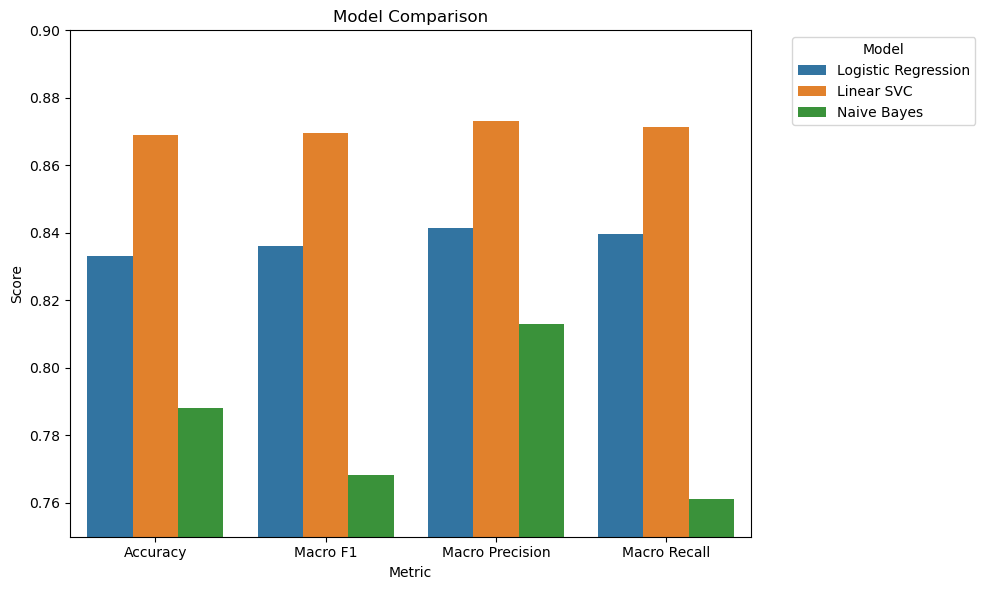

In [29]:
# Melt for plotting
df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Comparison')
plt.ylim(0.75, 0.90)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

- The best performing model from the barplot above is definitely the Linear SVC model

My metrics of success are:

**Accuracy** 
- Easy to understand; % of correct predictions out of all. Use for overall view.

**Macro F1 Score**: 
- It balances both precision and recall
- It doesn’t get skewed by class imbalance
- It's meaningful when every intent matters, not just the frequent ones

### **Hyperparameter Tuning for Best Model (i.e., LinearSVC)**

In [30]:
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])

# Define Hyperparameter Grid
param_grid = {
    'svc__class_weight': ['balanced'],
    'svc__random_state': [42],
    'svc__max_iter': [1000, 2000, 5000],
    'svc__C': [0.01, 0.1, 1, 10]
}

# Grid Search with 5-fold CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)

# Fit your data
grid_search.fit(X_train_raw, y_train)

# Print best model details
print("Best Parameters:", grid_search.best_params_)
print("Best Macro F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__max_iter': 1000, 'svc__random_state': 42}
Best Macro F1 Score: 0.8710511003971234


In [31]:
# Evaluate on test set

tuned_prediction = grid_search.predict(X_test_raw)
print(classification_report(y_test, tuned_prediction))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.91      0.94      0.92        32
                                activate_my_card       1.00      0.94      0.97        32
                                       age_limit       0.91      0.95      0.93        22
                         apple_pay_or_google_pay       1.00      0.96      0.98        25
                                     atm_support       0.89      0.94      0.91        17
                                automatic_top_up       1.00      0.96      0.98        25
         balance_not_updated_after_bank_transfer       0.87      0.76      0.81        34
balance_not_updated_after_cheque_or_cash_deposit       0.89      0.89      0.89        36
                         beneficiary_not_allowed       0.93      0.81      0.86        31
                                 cancel_transfer       0.94      0.94      0.94        31
         

### **Saving The Model**

In [32]:
# Save the entire GridSearchCV object

joblib.dump(grid_search, 'tuned_linear_svc_model.pkl')

['tuned_linear_svc_model.pkl']

### **TESTING MODEL ON UNSEEN DATA**

In [36]:
# Define the test data feature matrix

X_real_test = test_df['clean_text']

In [37]:
# Get the true labels

y_real_test = test_df['category']

#### **Load Model and Make Predictions**

In [38]:
# load my trained model

loaded_model = joblib.load('tuned_linear_svc_model.pkl')

# predict on the unseen data

y_real_pred = loaded_model.predict(X_real_test)

#### **Evaluate Model Performance on Test Data**

In [39]:
# Evaluate on the true test set
real_test_accuracy = accuracy_score(y_real_test, y_real_pred)
real_test_macro_f1 = f1_score(y_real_test, y_real_pred, average='macro')

print("✅ Final Evaluation on Real Test Set:")
print(f"Accuracy: {real_test_accuracy:.4f}")
print(f"Macro F1 Score: {real_test_macro_f1:.4f}")
print("\nFull Classification Report:")
print(classification_report(y_real_test, y_real_pred, zero_division=0))

✅ Final Evaluation on Real Test Set:
Accuracy: 0.8857
Macro F1 Score: 0.8856

Full Classification Report:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.83      0.85      0.84        40
                                activate_my_card       1.00      0.97      0.99        40
                                       age_limit       0.93      1.00      0.96        40
                         apple_pay_or_google_pay       0.97      0.97      0.97        40
                                     atm_support       0.93      0.95      0.94        40
                                automatic_top_up       0.97      0.93      0.95        40
         balance_not_updated_after_bank_transfer       0.73      0.75      0.74        40
balance_not_updated_after_cheque_or_cash_deposit       0.90      0.95      0.93        40
                         beneficiary_not_allowed       0.97      0.88      0.92    